# m2.1t.jl

Load Julia packages (libraries) needed

In [1]:
using TuringModels
using Optim, Turing, Flux.Tracker
gr(size=(600,300));

In [2]:
Turing.setadbackend(:reverse_diff);
Turing.turnprogress(false);

┌ Info: [Turing]: global PROGRESS is set as false
└ @ Turing /Users/rob/.julia/dev/Turing/src/Turing.jl:24


### snippet 2.8t

Define the data

In [3]:
k = 6; n = 9;

Define the model

In [4]:
@model globe_toss(n, k) = begin
  theta ~ Beta(1, 1) # prior
  k ~ Binomial(n, theta) # model
  return k, theta
end;

Compute the "maximum_a_posteriori" value

Set search bounds

In [5]:
lb = [0.0]; ub = [1.0];

Create (compile) the model

In [6]:
model = globe_toss(n, k);

Compute the maximum_a_posteriori

In [7]:
maximum_a_posteriori(model, lb, ub)

Results of Optimization Algorithm
 * Algorithm: Fminbox with L-BFGS
 * Starting Point: [0.4523778277380102]
 * Minimizer: [0.6666666665765391]
 * Minimum: 1.297811e+00
 * Iterations: 3
 * Convergence: true
   * |x - x'| ≤ 0.0e+00: false 
     |x - x'| = 7.14e-08 
   * |f(x) - f(x')| ≤ 0.0e+00 |f(x)|: false
     |f(x) - f(x')| = 7.96e-14 |f(x)|
   * |g(x)| ≤ 1.0e-08: true 
     |g(x)| = 2.89e-09 
   * Stopped by an increasing objective: false
   * Reached Maximum Number of Iterations: false
 * Objective Calls: 49
 * Gradient Calls: 49

Use Turing mcmc

In [8]:
chn = sample(model, Turing.NUTS(2000, 1000, 0.65));

┌ Info: [Turing] looking for good initial eps...
└ @ Turing.Inference /Users/rob/.julia/dev/Turing/src/inference/support/hmc_core.jl:240
[NUTS{Turing.Core.FluxTrackerAD,Union{}}] found initial ϵ: 0.8
└ @ Turing.Inference /Users/rob/.julia/dev/Turing/src/inference/support/hmc_core.jl:235
┌ Warning: 14.564740788309653 exceeds 5.0; capped to 5.0 for numerical stability
└ @ Turing.Inference /Users/rob/.julia/dev/Turing/src/inference/adapt/stepsize.jl:96
┌ Warning: 19.616286109295828 exceeds 5.0; capped to 5.0 for numerical stability
└ @ Turing.Inference /Users/rob/.julia/dev/Turing/src/inference/adapt/stepsize.jl:96
┌ Warning: 5.118644856756909 exceeds 5.0; capped to 5.0 for numerical stability
└ @ Turing.Inference /Users/rob/.julia/dev/Turing/src/inference/adapt/stepsize.jl:96
┌ Warning: 5.156473766542623 exceeds 5.0; capped to 5.0 for numerical stability
└ @ Turing.Inference /Users/rob/.julia/dev/Turing/src/inference/adapt/stepsize.jl:96
┌ Warning: 8.877452509758733 exceeds 5.0; capped t

Fix the inclusion of adaptation samples

In [9]:
chn2 = MCMCChains.Chains(chn.value[1001:2000,:,:],
  vcat(chn.name_map[:internals], chn.name_map[:parameters]),
  Dict(
    :parameters => chn.name_map[:parameters],
    :internals => chn.name_map[:internals]
  )
)

Object of type Chains, with data of type 1000×7×1 Array{Union{Missing, Float64},3}

Log evidence      = 0.0
Iterations        = 1:1000
Thinning interval = 1
Chains            = Chain1
Samples per chain = 1000
internals         = elapsed, epsilon, eval_num, lf_eps, lf_num, lp
parameters        = theta

parameters
       Mean    SD   Naive SE  MCSE     ESS  
theta 0.6272 0.1408   0.0045 0.0069 412.9173



Look at the proper draws (in corrected chn2)

In [10]:
describe(chn2)

Log evidence      = 0.0
Iterations        = 1:1000
Thinning interval = 1
Chains            = Chain1
Samples per chain = 1000
parameters        = theta

Empirical Posterior Estimates:
parameters
       Mean    SD   Naive SE  MCSE     ESS  
theta 0.6272 0.1408   0.0045 0.0069 412.9173

Quantiles:
parameters
       2.5%  25.0%  50.0%  75.0%  97.5%
theta 0.1999 0.531 0.6294 0.7334 0.9592



Show the hpd region

In [11]:
MCMCChains.hpd(chn2, alpha=0.055)

Log evidence      = 0.0
Iterations        = 1:1000
Thinning interval = 1
Chains            = Chain1
Samples per chain = 1000
internals         = elapsed, epsilon, eval_num, lf_eps, lf_num, lp
parameters        = theta

parameters
      94.5% Lower 94.5% Upper
theta  0.34565251   0.8642323



Compute the hpd bounds for plotting

In [12]:
d, p, c = size(chn2);
theta = convert(Vector{Float64}, reshape(chn2.value[:, 7, :], (d*c)));
bnds = quantile(theta, [0.045, 0.945])

2-element Array{Float64,1}:
 0.3764627726543889
 0.8455235601993734

Show hpd region

In [13]:
println("hpd bounds = $bnds\n")

hpd bounds = [0.3764627726543889, 0.8455235601993734]



analytical calculation

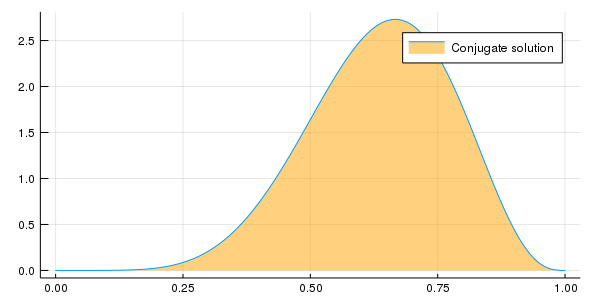

In [14]:
w = 6; n = 9; x = 0:0.01:1
plot( x, pdf.(Beta( w+1 , n-w+1 ) , x ), fill=(0, .5,:orange), lab="Conjugate solution")

quadratic approximation

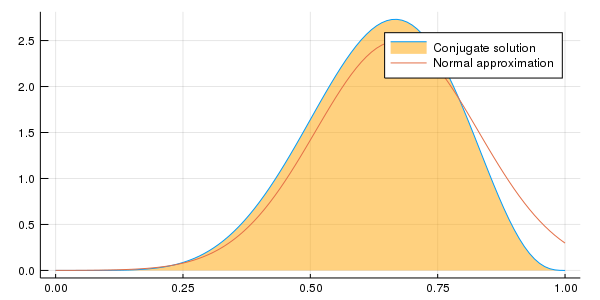

In [15]:
plot!( x, pdf.(Normal( 0.67 , 0.16 ) , x ), lab="Normal approximation")

Turing Chain &  89%hpd region boundaries

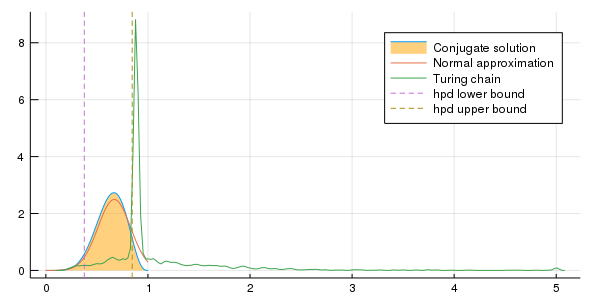

In [16]:
#tmp = convert(Array{Float64,3}, chn.value[:, 4, :])
#draws = reshape(tmp, (size(tmp, 1)*size(tmp, 3)),)
density!(chn.value[:, 2, 1], lab="Turing chain")
vline!([bnds[1]], line=:dash, lab="hpd lower bound")
vline!([bnds[2]], line=:dash, lab="hpd upper bound")

End of `02/m2.1t.jl`

*This notebook was generated using [Literate.jl](https://github.com/fredrikekre/Literate.jl).*